## Quarterly Trading Strategy Using Random Forest, Adaboost, Gradient Boosted Trees, and Voting Classifier
Final Project <br>
Machine Learning in Finance <br>
March 14, 2020 <br>
Eddie Shim

Data is provided by WRDS database and spans quarterly metrics across 2000-01-01 to 2018-12-31 and covers all US equity symbols with greater than $1B market cap (>4000 symbols). Total dataset size is about 110k rows and 700 columns (~600KB). <br>
Our goal is to create a trading strategy that takes a look at >700 features per company per quarter and predict which set of equities we should buy and sell in the upcoming quarter. Feature description is detailed in Key to Abbreviations.pdf<br>
<br>
The notebook will detail comparisons of Random Forest, Adaboost, and GBM. Hyperparams are calibrated using GridSearchCV and feature set is derived from a pre-cached set of optimal features.
<br>
Key evaluation metrics per strategy/model include alpha, information ratio, sharpe ratio, maximum drawdown, and comparisons of relative profit performance benchmarked against SPY.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
import lightgbm as lgb
pd.set_option('use_inf_as_na', True)
from collections import Counter
import pickle
from hypopt import GridSearch
from sklearn.model_selection import GridSearchCV

In [3]:
raw_data = pd.read_pickle(r'C:\Users\eddie\Documents\MSCS\Machine Learning\week1\dataset.pkl')
data = raw_data[raw_data['market_cap'] > 1000.0]
data.fillna(0.0,inplace=True)

C:\Users\eddie\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [4]:
#defining our dependent variable, a categorical value for whether stock outperformed or underperformed SPY by over 1%
def relative_performance_transform(x):
    if x > 0.01:
        return 1
    elif x < -0.01:
        return -1
    else:    
        return 0

In [5]:
data['rel_performance'] = data['pred_rel_return'].apply(relative_performance_transform)
data.reset_index(inplace=True,)
data.set_index('date',inplace=True)

C:\Users\eddie\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [6]:
#data descriptive stats
print("Data frame shape:", data.shape)
print("Number of unique symbols:", data[['ticker']].nunique())
data.head()

Data frame shape: (111468, 733)
Number of unique symbols: ticker    4076
dtype: int64


,ticker,actq,apq,atq,ceqq,cheq,cogsq,csh12q,cshfdq,cshiq,...,sector_code_817.0,sector_code_822.0,sector_code_823.0,sector_code_825.0,sector_code_830.0,sector_code_835.0,sector_code_840.0,sector_code_845.0,sector_code_850.0,rel_performance
date,,,,,,,,,,,,,,,,,,,,,
2000-02-09,CSCO,7722.000,482.000,21391.000,16523.000,3968.000,1422.000,3374.1250,3648.000,3445.000,...,0,0,0,0,0,0,0,0,0,-1
2000-02-09,ROP,172.725,19.662,474.649,239.432,3.198,47.634,30.2688,31.217,0.000,...,0,0,0,0,0,0,0,0,0,1
2000-02-10,CMOS,240.767,27.044,376.536,209.411,68.625,43.023,21.4360,23.753,0.000,...,0,0,0,0,0,0,0,0,0,1
2000-02-11,DELL,7681.000,3538.000,11471.000,5308.000,4132.000,5452.000,2536.0000,2731.000,2575.000,...,0,0,0,0,0,0,0,0,0,1
2000-02-15,VAL,507.082,139.497,1094.080,402.382,27.605,221.366,43.1858,43.687,53.321,...,0,0,0,0,0,0,0,0,0,1


From the nine optimal features files:<br>
    &emsp; 1.ada opt feat 4.pkl<br>
    &emsp; 2.ada opt feat 5.pkl<br>
    &emsp; 3.ada opt feat 6.pkl<br>
    &emsp; 4.gb opt feat 1.pkl<br>
    &emsp; 5.gb opt feat 2.pkl<br>
    &emsp; 6.gb opt feat 3.pkl<br>
    &emsp; 7.opt feat 4.pkl<br>
    &emsp; 8.opt feat 5.pkl<br>
    &emsp; 9.opt feat 6.pkl<br>
Each of these files contain a list of lists of optimal features for various classifiers.<br>
Compute the frequency for each feature which occurs as an optimal feature in the totality<br>
of these files.

In [8]:
#Load in cached optimal feature sets 
with open(r'C:\Users\eddie\Documents\MSCS\Machine Learning\week5\hw3\ada_opt_feat_4.pkl','rb') as f:
    ada_opt_feat4 = pickle.load(f)
with open(r'C:\Users\eddie\Documents\MSCS\Machine Learning\week5\hw3\ada_opt_feat_5.pkl','rb') as f:
    ada_opt_feat5 = pickle.load(f)
with open(r'C:\Users\eddie\Documents\MSCS\Machine Learning\week5\hw3\ada_opt_feat_6.pkl','rb') as f:
    ada_opt_feat6 = pickle.load(f)
with open(r'C:\Users\eddie\Documents\MSCS\Machine Learning\week7\gb_opt_feat_1.pkl','rb') as f:
    gb_opt_feat1 = pickle.load(f)
with open(r'C:\Users\eddie\Documents\MSCS\Machine Learning\week7\gb_opt_feat_2.pkl','rb') as f:
    gb_opt_feat2 = pickle.load(f)
with open(r'C:\Users\eddie\Documents\MSCS\Machine Learning\week7\gb_opt_feat_3.pkl','rb') as f:
    gb_opt_feat3 = pickle.load(f)
with open(r'C:\Users\eddie\Documents\MSCS\Machine Learning\week5\hw3\opt_feat_4.pkl','rb') as f:
    opt_feat4 = pickle.load(f)
with open(r'C:\Users\eddie\Documents\MSCS\Machine Learning\week5\hw3\opt_feat_4.pkl','rb') as f:
    opt_feat5 = pickle.load(f)
with open(r'C:\Users\eddie\Documents\MSCS\Machine Learning\week5\hw3\opt_feat_4.pkl','rb') as f:
    opt_feat6 = pickle.load(f)

In [9]:
#Compute frequency for each feature which occurs as optimal feature and grab top 10
frequency_table = Counter()
feature_sets = [ada_opt_feat4, ada_opt_feat5, ada_opt_feat6, gb_opt_feat1, gb_opt_feat2, gb_opt_feat3, opt_feat4, opt_feat5, opt_feat6]
for fset in feature_sets:
    for fset_subset in fset:
        frequency_table += Counter(fset_subset)
top10features = [ft for ft, count in frequency_table.most_common(10)]
print(top10features)

['fcf_yield', 'evmq', 'cf_yield', 'oancfy_q', 'fcf_csfhdq', 'chechy', 'capeiq', 'lt_ppentq', 'xsgay', 'fcf_ocfq']


From our results above, here are the top 10 features we'll be proceeding with for the rest of our models:
1. fcf_yield: free cash flow yield
2. evmq: enterprise value quarterly
3. cf_yield: cash flow yield
4. oancfy_q: operating expenses - net cash flow
5. fcf_csfhdq: free cash flow 
6. chechy: cash and cash equivalents
7. capeiq: capital investment quarterly
8. lt_ppentq: long percentage point enterprise quarterly
9. xsgay: selling, general and administrative expensives
10. fcf_ocfq: free cash flow operations cash flow quarterly

Pick a set of 10 features with the highest frequencies and run several back tests with <br>
different sets of hyper parameters, using this set of 10 features through the whole period <br>
(so we do not change features each quarter) for each of the three classifiers below. Find<br>
the hyper parameters for each classifier from these experiments that give the best Sharpe<br>
Ratio<br>
&emsp;-A Random Forest Classifier<br>
&emsp;-An AdaBoosting Classifier<br>
&emsp;-A Gradient Boosting Classifier<br>

In [10]:
#Split our training and test dataframes 
start_dates = [pd.to_datetime('2000-01-01') + pd.DateOffset(months = 3 * i) for i in range(62)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
test_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]

training_data_full = [d for d in training_frames]

training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_performance'].values for d in training_frames]
validation_labels = [d['rel_performance'].values for d in test_frames]

In [14]:
#Using first three years as separate training dataset to feed into our hyperparam gridsearch
df_hyperparam_train = data.loc['2010-01-01':'2013-01-01']
input_data_hyperparam = df_hyperparam_train.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)
label_data_hyperparam = df_hyperparam_train['rel_performance'].values

In [15]:
#Load in SPY data as benchmark measure and for Sharpe Ratio calculation
SPY = pd.read_pickle(r'C:\Users\eddie\Documents\MSCS\Machine Learning\week2\SPY_cum_ret.pkl')
SPY = SPY.loc['2003-10-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)

# Trading Strategy Style 1

Compute the total P/L for the strategy where for each quarter we allocate our capital
equally between the stocks we consider in the quarter, the stocks that are available will
vary from quarter to quarter. We go long each stock with prediction +1, and short each
stock with prediction -1 (and do nothing if the prediction is 0) and hold until the day after
the next earnings release. We start with $1. Compute SR, IR, alpha, max drawdown(on an annual basis).

In [16]:
def calc_strategy_returns_style1(training_data, training_labels, test_frames, test_data, top10features, model_with_hyper_params):
    P_L = []
    strategy_returns = [0,1]
    ret = []

    for i in range(1,len(training_data)-1):
            model_with_hyper_params.fit(training_data[i][top10features],training_labels[i])
            pred_i = model_with_hyper_params.predict(test_data[i][top10features])                

            profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
            P_L.append(profit_i)
            positions = np.sum(np.abs(pred_i))

            ret.append((1.0/positions) * profit_i)
            strategy_returns.append(strategy_returns[i] + (strategy_returns[i]/positions) * profit_i)
    strategy_returns = strategy_returns[1:]
    return(strategy_returns)

# Trading Strategy Style 2

Consider the strategy where we buy the stock and short the SPY if the prediction is +1
and do the opposite if the prediction is -1, with the same allocation to each trade as above
and same holding period.
Compute total P/L for this strategy.
Compute SR, IR, alpha, MaxDrawdown (on an annual basis).

In [17]:
def calc_strategy_returns_style2(training_data, training_labels, test_frames, test_data, top10features, model_with_hyper_params):
    P_L = []
    strategy_returns = [0,1]
    ret = []

    for i in range(1,len(training_data)-1):
            model_with_hyper_params.fit(training_data[i][top10features],training_labels[i])
            pred_i = model_with_hyper_params.predict(test_data[i][top10features])  
            
            spy_next_period_ret = training_data_full[i]['spy_next_period_return']
            
            profit_i = 0
            for p_index in range(0,len(pred_i)):
                p = pred_i[p_index]
                profit_i_stock = test_frames[i]['next_period_return'][p_index]
                profit_i_spy = test_frames[i]['spy_next_period_return'][p_index]
                
                if(p > 0): #buy the stock and short the SPY
                    profit_i = profit_i + profit_i_stock - profit_i_spy
                elif(p < 0): #short the stock and buy the SPY
                    profit_i = profit_i - profit_i_stock + profit_i_spy

            P_L.append(profit_i)
            positions = np.sum(np.abs(pred_i))

            ret.append((1.0/positions) * profit_i)
            strategy_returns.append(strategy_returns[i] + (strategy_returns[i]/positions) * profit_i)
    strategy_returns = strategy_returns[1:]
    return(strategy_returns)

In [18]:
def calc_max_drawdown(returns):
    i = np.argmax(np.maximum.accumulate(returns) - returns)
    j = np.argmax(returns[:i])
    return np.abs(returns[j] - returns[i])

In [19]:
def calc_sharpe_ratio(returns_spy_strategy):
    strategy_mean_ret = (returns_spy_strategy.iloc[:,1] - 1).diff().mean()
    strategy_std = (returns_spy_strategy.iloc[:,1] - 1).diff().std()
    strategy_sr = strategy_mean_ret/strategy_std
    return(strategy_sr)

In [20]:
def calc_beta(strategy_returns, spy_returns):
    beta = (np.cov(spy_returns,strategy_returns)/np.var(spy_returns))[1,0]
    return(beta)

In [21]:
def calc_information_ratio(strategy_returns, spy_returns):
    beta = calc_beta(strategy_returns, spy_returns)
    residual_ret = strategy_returns - beta * spy_returns
    IR = np.mean(residual_ret)/np.std(residual_ret)
    return(IR)

In [22]:
def calc_alpha(strategy_returns, spy_returns):
    beta = calc_beta(strategy_returns, spy_returns)
    residual_ret = strategy_returns - beta * spy_returns
    alpha = np.mean(residual_ret)
    return(alpha)

In [125]:
results = pd.DataFrame(columns = ["model_type", "hyper_parameters", "max_drawdown", 
                                  "sharpe_ratio", "alpha", "information_ratio", "returns_sd"])

In [126]:
results_graph_data = pd.DataFrame(columns = ["SPY", 
                                             "RandomForest_Strat1", "RandomForest_Strat2", 
                                             "AdaBoost_Strat1","AdaBoost_Strat2",
                                             "GB_Strat1","GB_Strat2",
                                             "Voting_Strat1", "Voting_Strat2"])
results_graph_data["SPY"] = SPY["spy_cum_ret"]

# Random Forest Classifier

In [55]:
#Use GridSearchCV in order to find our best hyperparam set
param_grid_rf = [
  {'n_estimators': [10,100], 
   'max_features': [.2,.6],
   'min_samples_leaf':[2000,5000],
   'max_depth':[5,20,100]}    
 ]

In [56]:
rf_clf = RandomForestClassifier()
search_rf = GridSearchCV(cv=3,
                estimator = rf_clf, 
                param_grid = param_grid_rf)
search_rf.fit(input_data_hyperparam[top10features], label_data_hyperparam)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [57]:
search_rf.best_params_

{'max_depth': 20,
 'max_features': 0.2,
 'min_samples_leaf': 2000,
 'n_estimators': 100}

In [58]:
rf_clf.set_params(**search_rf.best_params_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features=0.2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2000, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [59]:
strategy_returns_rf1 = calc_strategy_returns_style1(training_data, training_labels, test_frames, test_data, top10features, rf_clf)
strategy_returns_rf2 = calc_strategy_returns_style2(training_data, training_labels, test_frames, test_data, top10features, rf_clf)

In [127]:
returns_spy_strategy_rf = SPY.copy()

In [128]:
returns_spy_strategy_rf['strategy1'] = strategy_returns_rf1
returns_spy_strategy_rf['strategy2'] = strategy_returns_rf2
results_graph_data['RandomForest_Strat1'] = strategy_returns_rf1
results_graph_data['RandomForest_Strat2'] = strategy_returns_rf2

In [129]:
#annualize results
returns_spy_strategy_rf = returns_spy_strategy_rf.resample('A').bfill()
print(returns_spy_strategy_rf)

            spy_cum_ret  strategy1  strategy2
date                                         
2003-12-31     1.000000   1.000000   1.000000
2004-12-31     1.107865   1.190186   1.055796
2005-12-31     1.160316   1.522921   1.176728
2006-12-31     1.312439   1.663719   1.211752
2007-12-31     1.375107   2.028168   1.251139
2008-12-31     1.001322   1.849084   1.292379
2009-12-31     1.270714   1.621277   1.394861
2010-12-31     1.427042   2.014411   1.524981
2011-12-31     1.472251   2.361503   1.557879
2012-12-31     1.628635   2.598567   1.486738
2013-12-31     1.914856   3.356594   1.579921
2014-12-31     2.047496   3.722409   1.577883
2015-12-31     2.071800   3.990455   1.678477
2016-12-31     2.193680   3.839377   1.647199
2017-12-31     2.392402   4.120909   1.675078
2018-12-31     2.360201   4.374602   1.693795


In [130]:
rf_returns_sd1 = np.std(returns_spy_strategy_rf['strategy1'])
rf_returns_sd2 = np.std(returns_spy_strategy_rf['strategy2'])

In [131]:
max_dd_rf1 = calc_max_drawdown(returns_spy_strategy_rf['strategy1'])
max_dd_rf2 = calc_max_drawdown(returns_spy_strategy_rf['strategy2'])

In [132]:
sharpe_ratio_rf1 = calc_sharpe_ratio(returns_spy_strategy_rf[['spy_cum_ret', 'strategy1']])
sharpe_ratio_rf2 = calc_sharpe_ratio(returns_spy_strategy_rf[['spy_cum_ret', 'strategy2']])

In [133]:
strategy_ret_normalized_rf1 = (returns_spy_strategy_rf['strategy1'] - 1).diff().values[1:]
spy_ret_normalized_rf1 = (returns_spy_strategy_rf['spy_cum_ret'] - 1).diff().values[1:]
information_ratio_rf1 = calc_information_ratio(strategy_ret_normalized_rf1, spy_ret_normalized_rf1)

strategy_ret_normalized_rf2 = (returns_spy_strategy_rf['strategy2'] - 1).diff().values[1:]
spy_ret_normalized_rf2 = (returns_spy_strategy_rf['spy_cum_ret'] - 1).diff().values[1:]
information_ratio_rf2 = calc_information_ratio(strategy_ret_normalized_rf2, spy_ret_normalized_rf2)

In [134]:
alpha_rf1 = calc_alpha(strategy_ret_normalized_rf1, spy_ret_normalized_rf1)
alpha_rf2 = calc_alpha(strategy_ret_normalized_rf2, spy_ret_normalized_rf2)

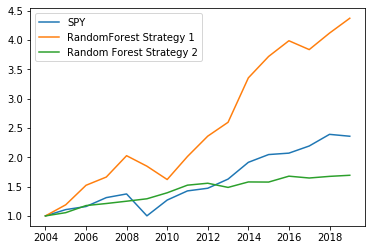

In [135]:
plt.plot(returns_spy_strategy_rf)
plt.legend(['SPY','RandomForest Strategy 1', 'Random Forest Strategy 2'])

In [136]:
results = results.append({"model_type":"random_forest_strat1", "hyper_parameters":rf_clf.get_params(), "max_drawdown":max_dd_rf1, 
                "sharpe_ratio":sharpe_ratio_rf1, "alpha":alpha_rf1, "information_ratio":information_ratio_rf1,
                         "returns_sd":rf_returns_sd1}, ignore_index=True)
results = results.append({"model_type":"random_forest_strat2", "hyper_parameters":rf_clf.get_params(), "max_drawdown":max_dd_rf2, 
                "sharpe_ratio":sharpe_ratio_rf2, "alpha":alpha_rf2, "information_ratio":information_ratio_rf2,
                         "returns_sd":rf_returns_sd2}, ignore_index=True)

In [137]:
display(results)

,model_type,hyper_parameters,max_drawdown,sharpe_ratio,alpha,information_ratio,returns_sd
0,random_forest_strat1,"{'bootstrap': True, 'class_weight': None, 'cri...",0.406891,0.886202,0.168042,0.733543,1.106498
1,random_forest_strat2,"{'bootstrap': True, 'class_weight': None, 'cri...",0.071141,0.819332,0.043336,0.797313,0.223610


# Adaboost Classifier

In [105]:
#Use GridSearchCV in order to find our best hyperparam set
param_grid_ada = [
  {'n_estimators': [5, 10,50], 
   'learning_rate':[.2,.6],
   'algorithm': ["SAMME.R"]}    
 ]

In [109]:
#Using DST with some depth feeding into AdaBoost. I experimented with default DSTs, which results in an underfitted Adaboost
dst_clf = DecisionTreeClassifier(max_depth = 5) 
ada_clf = AdaBoostClassifier(dst_clf)

In [110]:
search_ada = GridSearchCV(cv=3,
                estimator = ada_clf,
                param_grid = param_grid_ada)
search_ada.fit(input_data_hyperparam[top10features], label_data_hyperparam)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=5,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
                                                                                min

In [111]:
search_ada.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 0.2, 'n_estimators': 5}

In [112]:
ada_clf.set_params(**search_ada.best_params_)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=5,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

In [113]:
strategy_returns_ada1 = calc_strategy_returns_style1(training_data, training_labels, test_frames, test_data, top10features, ada_clf)
strategy_returns_ada2 = calc_strategy_returns_style2(training_data, training_labels, test_frames, test_data, top10features, ada_clf)

In [138]:
returns_spy_strategy_ada = SPY.copy()

In [139]:
returns_spy_strategy_ada['strategy1'] = strategy_returns_ada1
returns_spy_strategy_ada['strategy2'] = strategy_returns_ada2
results_graph_data['AdaBoost_Strat1'] = strategy_returns_ada1
results_graph_data['AdaBoost_Strat2'] = strategy_returns_ada2

In [140]:
#annualize results
returns_spy_strategy_ada = returns_spy_strategy_ada.resample('A').bfill()
print(returns_spy_strategy_ada)

            spy_cum_ret  strategy1  strategy2
date                                         
2003-12-31     1.000000   1.000000   1.000000
2004-12-31     1.107865   1.169440   1.056695
2005-12-31     1.160316   1.447149   1.171991
2006-12-31     1.312439   1.573140   1.205424
2007-12-31     1.375107   1.851245   1.248788
2008-12-31     1.001322   1.802006   1.306055
2009-12-31     1.270714   1.659130   1.364301
2010-12-31     1.427042   1.962792   1.467164
2011-12-31     1.472251   2.237915   1.506533
2012-12-31     1.628635   2.421369   1.466077
2013-12-31     1.914856   2.814204   1.513780
2014-12-31     2.047496   3.055629   1.533640
2015-12-31     2.071800   3.237520   1.624379
2016-12-31     2.193680   3.175632   1.597231
2017-12-31     2.392402   3.395423   1.627071
2018-12-31     2.360201   3.650621   1.671960


In [141]:
ada_returns_sd1 = np.std(returns_spy_strategy_ada['strategy1'])
ada_returns_sd2 = np.std(returns_spy_strategy_ada['strategy2'])

In [142]:
max_dd_ada1 = calc_max_drawdown(returns_spy_strategy_ada['strategy1'])
max_dd_ada2 = calc_max_drawdown(returns_spy_strategy_ada['strategy2'])

In [143]:
sharpe_ratio_ada1 = calc_sharpe_ratio(returns_spy_strategy_ada[['spy_cum_ret', 'strategy1']])
sharpe_ratio_ada2 = calc_sharpe_ratio(returns_spy_strategy_ada[['spy_cum_ret', 'strategy2']])

In [144]:
strategy_ret_normalized_ada1 = (returns_spy_strategy_ada['strategy1'] - 1).diff().values[1:]
spy_ret_normalized_ada1 = (returns_spy_strategy_ada['spy_cum_ret'] - 1).diff().values[1:]
information_ratio_ada1 = calc_information_ratio(strategy_ret_normalized_ada1, spy_ret_normalized_ada1)

strategy_ret_normalized_ada2 = (returns_spy_strategy_ada['strategy2'] - 1).diff().values[1:]
spy_ret_normalized_ada2 = (returns_spy_strategy_ada['spy_cum_ret'] - 1).diff().values[1:]
information_ratio_ada2 = calc_information_ratio(strategy_ret_normalized_ada2, spy_ret_normalized_ada2)

In [145]:
alpha_ada1 = calc_alpha(strategy_ret_normalized_ada1, spy_ret_normalized_ada1)
alpha_ada2 = calc_alpha(strategy_ret_normalized_ada2, spy_ret_normalized_ada2)

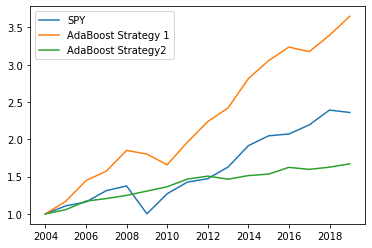

In [146]:
plt.plot(returns_spy_strategy_ada)
plt.legend(['SPY','AdaBoost Strategy 1', 'AdaBoost Strategy2'])

In [147]:
results = results.append({"model_type":"ada_boost_strat1", "hyper_parameters":ada_clf.get_params(), "max_drawdown":max_dd_ada1, 
                "sharpe_ratio":sharpe_ratio_ada1, "alpha":alpha_ada1, "information_ratio":information_ratio_ada1,
                         "returns_sd": ada_returns_sd1}, ignore_index=True)
results = results.append({"model_type":"ada_boost_strat2", "hyper_parameters":ada_clf.get_params(), "max_drawdown":max_dd_ada2, 
                "sharpe_ratio":sharpe_ratio_ada2, "alpha":alpha_ada2, "information_ratio":information_ratio_ada2,
                         "returns_sd": ada_returns_sd2}, ignore_index=True)

In [148]:
display(results)

,model_type,hyper_parameters,max_drawdown,sharpe_ratio,alpha,information_ratio,returns_sd
0,random_forest_strat1,"{'bootstrap': True, 'class_weight': None, 'cri...",0.406891,0.886202,0.168042,0.733543,1.106498
1,random_forest_strat2,"{'bootstrap': True, 'class_weight': None, 'cri...",0.071141,0.819332,0.043336,0.797313,0.223610
2,ada_boost_strat1,"{'algorithm': 'SAMME.R', 'base_estimator__clas...",0.192115,1.172459,0.155250,1.094747,0.818302
3,ada_boost_strat2,"{'algorithm': 'SAMME.R', 'base_estimator__clas...",0.040456,1.073291,0.049262,1.239814,0.204080


# Gradient Boosting Classifer

In [149]:
#Use GridSearchCV in order to find our best hyperparam set
param_grid_gb = [
  {'n_estimators': [10,100], 
   'max_depth': [1,3,5,10],
   'objective': ['multi_class'],
   'reg_lambda': [.2, .6],
   'learning_rate':[.2, .6]}
 ]

In [150]:
gb_clf = lgb.LGBMClassifier()
search_gb = GridSearchCV(cv=3,
                estimator = gb_clf, 
                param_grid = param_grid_gb)
search_gb.fit(input_data_hyperparam[top10features], label_data_hyperparam)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid=[{'learning_rate': [0.2, 0.6],
                          'ma

In [166]:
search_gb.best_params_

{'learning_rate': 0.2,
 'max_depth': 3,
 'n_estimators': 100,
 'objective': 'multi_class',
 'reg_lambda': 0.2}

In [167]:
gb_clf.set_params(**search_gb.best_params_)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.2, max_depth=3,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31,
               objective='multi_class', random_state=None, reg_alpha=0.0,
               reg_lambda=0.2, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [168]:
strategy_returns_gb1 = calc_strategy_returns_style1(training_data, training_labels, test_frames, test_data, top10features, gb_clf)
strategy_returns_gb2 = calc_strategy_returns_style2(training_data, training_labels, test_frames, test_data, top10features, gb_clf)

In [154]:
returns_spy_strategy_gb = SPY.copy()

In [155]:
returns_spy_strategy_gb['strategy1'] = strategy_returns_gb1
returns_spy_strategy_gb['strategy2'] = strategy_returns_gb2
results_graph_data['GB_Strat1'] = strategy_returns_gb1
results_graph_data['GB_Strat2'] = strategy_returns_gb2

In [156]:
#annualize results
returns_spy_strategy_gb = returns_spy_strategy_gb.resample('A').bfill()
print(returns_spy_strategy_gb)

            spy_cum_ret  strategy1  strategy2
date                                         
2003-12-31     1.000000   1.000000   1.000000
2004-12-31     1.107865   1.160798   1.055208
2005-12-31     1.160316   1.426645   1.165429
2006-12-31     1.312439   1.554494   1.212150
2007-12-31     1.375107   1.800195   1.255301
2008-12-31     1.001322   1.794482   1.322379
2009-12-31     1.270714   1.750631   1.362120
2010-12-31     1.427042   2.038340   1.450211
2011-12-31     1.472251   2.328626   1.491873
2012-12-31     1.628635   2.535001   1.487057
2013-12-31     1.914856   2.838286   1.518150
2014-12-31     2.047496   3.021929   1.519580
2015-12-31     2.071800   3.234443   1.619425
2016-12-31     2.193680   3.198282   1.597594
2017-12-31     2.392402   3.342829   1.612696
2018-12-31     2.360201   3.549716   1.660852


In [157]:
gb_returns_sd1 = np.std(returns_spy_strategy_gb['strategy1'])
gb_returns_sd2 = np.std(returns_spy_strategy_gb['strategy2'])

In [158]:
max_dd_gb1 = calc_max_drawdown(returns_spy_strategy_gb['strategy1'])
max_dd_gb2 = calc_max_drawdown(returns_spy_strategy_gb['strategy2'])

C:\Users\eddie\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


In [159]:
sharpe_ratio_gb1 = calc_sharpe_ratio(returns_spy_strategy_gb[['spy_cum_ret', 'strategy1']])
sharpe_ratio_gb2 = calc_sharpe_ratio(returns_spy_strategy_gb[['spy_cum_ret', 'strategy2']])

In [160]:
strategy_ret_normalized_gb1 = (returns_spy_strategy_gb['strategy1'] - 1).diff().values[1:]
spy_ret_normalized_gb1 = (returns_spy_strategy_gb['spy_cum_ret'] - 1).diff().values[1:]
information_ratio_gb1 = calc_information_ratio(strategy_ret_normalized_gb1, spy_ret_normalized_gb1)

strategy_ret_normalized_gb2 = (returns_spy_strategy_gb['strategy2'] - 1).diff().values[1:]
spy_ret_normalized_gb2 = (returns_spy_strategy_gb['spy_cum_ret'] - 1).diff().values[1:]
information_ratio_gb2 = calc_information_ratio(strategy_ret_normalized_gb2, spy_ret_normalized_gb2)

In [161]:
alpha_gb1 = calc_alpha(strategy_ret_normalized_gb1, spy_ret_normalized_gb1)
alpha_gb2 = calc_alpha(strategy_ret_normalized_gb2, spy_ret_normalized_gb2)

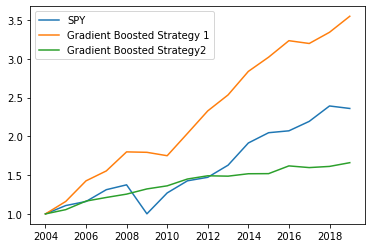

In [162]:
plt.plot(returns_spy_strategy_gb)
plt.legend(['SPY','Gradient Boosted Strategy 1', 'Gradient Boosted Strategy2'])

In [163]:
results = results.append({"model_type":"gradient_boost_strat1", "hyper_parameters":gb_clf.get_params(), "max_drawdown":max_dd_gb1, 
                "sharpe_ratio":sharpe_ratio_gb1, "alpha":alpha_gb1, "information_ratio":information_ratio_gb1,
                         "returns_sd": gb_returns_sd1}, ignore_index=True)
results = results.append({"model_type":"gradient_boost_strat2", "hyper_parameters":gb_clf.get_params(), "max_drawdown":max_dd_gb2, 
                "sharpe_ratio":sharpe_ratio_gb2, "alpha":alpha_gb2, "information_ratio":information_ratio_gb2,
                         "returns_sd": gb_returns_sd2}, ignore_index=True)

In [164]:
display(results)

,model_type,hyper_parameters,max_drawdown,sharpe_ratio,alpha,information_ratio,returns_sd
0,random_forest_strat1,"{'bootstrap': True, 'class_weight': None, 'cri...",0.406891,0.886202,0.168042,0.733543,1.106498
1,random_forest_strat2,"{'bootstrap': True, 'class_weight': None, 'cri...",0.071141,0.819332,0.043336,0.797313,0.223610
2,ada_boost_strat1,"{'algorithm': 'SAMME.R', 'base_estimator__clas...",0.192115,1.172459,0.155250,1.094747,0.818302
3,ada_boost_strat2,"{'algorithm': 'SAMME.R', 'base_estimator__clas...",0.040456,1.073291,0.049262,1.239814,0.204080
4,gradient_boost_strat1,"{'boosting_type': 'gbdt', 'class_weight': None...",0.049563,1.469581,0.155672,1.420951,0.805261
5,gradient_boost_strat2,"{'boosting_type': 'gbdt', 'class_weight': None...",0.021832,1.174899,0.052000,1.524780,0.200711


# Voting Classifier

Next use the best hyper parameters you found for each classifier and the 10 features to <br>
make a Voting Classifier (see the documentation for VotingClassifier in sklearn) and run <br>
a back test for this classifier, computing SR, IR, alpha and maximum drawdown

In [169]:
voting_clf = VotingClassifier(estimators = [('rf', rf_clf), 
                                            ('ada', ada_clf), 
                                            ('gb', gb_clf)], 
                              voting = 'soft')
voting_clf = voting_clf.fit(input_data_hyperparam[top10features], label_data_hyperparam)

In [170]:
strategy_returns_voting = calc_strategy_returns_style1(training_data, training_labels, test_frames, test_data, top10features, voting_clf)

In [171]:
returns_spy_strategy_voting = SPY.copy()

In [172]:
returns_spy_strategy_voting['strategy'] = strategy_returns_voting
results_graph_data['VotingClassifierStrat1'] = strategy_returns_voting

In [173]:
#annualize results
returns_spy_strategy_voting = returns_spy_strategy_voting.resample('A').bfill()
print(returns_spy_strategy_voting)

            spy_cum_ret  strategy
date                             
2003-12-31     1.000000  1.000000
2004-12-31     1.107865  1.165982
2005-12-31     1.160316  1.473248
2006-12-31     1.312439  1.605309
2007-12-31     1.375107  1.908702
2008-12-31     1.001322  1.860578
2009-12-31     1.270714  1.738947
2010-12-31     1.427042  2.071488
2011-12-31     1.472251  2.388548
2012-12-31     1.628635  2.612748
2013-12-31     1.914856  3.090419
2014-12-31     2.047496  3.346174
2015-12-31     2.071800  3.606709
2016-12-31     2.193680  3.533640
2017-12-31     2.392402  3.751483
2018-12-31     2.360201  4.032929


In [174]:
voting_returns_sd1 = np.std(returns_spy_strategy_voting['strategy'])

In [175]:
max_dd_voting = calc_max_drawdown(returns_spy_strategy_voting['strategy'])

C:\Users\eddie\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


In [177]:
sharpe_ratio_voting = calc_sharpe_ratio(returns_spy_strategy_voting[['spy_cum_ret','strategy']])

In [178]:
strategy_ret_normalized_voting = (returns_spy_strategy_voting['strategy'] - 1).diff().values[1:]
spy_ret_normalized_voting = (returns_spy_strategy_voting['spy_cum_ret'] - 1).diff().values[1:]
information_ratio_voting = calc_information_ratio(strategy_ret_normalized_voting, spy_ret_normalized_voting)

In [179]:
alpha_voting = calc_alpha(strategy_ret_normalized_voting, spy_ret_normalized_voting)

In [180]:
results = results.append({"model_type":"voting_classifier_strat1", "hyper_parameters":voting_clf.get_params(), "max_drawdown":max_dd_voting, 
                "sharpe_ratio":sharpe_ratio_voting, "alpha":alpha_voting, "information_ratio":information_ratio_voting,
                         "returns_sd": voting_returns_sd1}, ignore_index=True)

In [181]:
display(results)

,model_type,hyper_parameters,max_drawdown,sharpe_ratio,alpha,information_ratio,returns_sd
0,random_forest_strat1,"{'bootstrap': True, 'class_weight': None, 'cri...",0.406891,0.886202,0.168042,0.733543,1.106498
1,random_forest_strat2,"{'bootstrap': True, 'class_weight': None, 'cri...",0.071141,0.819332,0.043336,0.797313,0.223610
2,ada_boost_strat1,"{'algorithm': 'SAMME.R', 'base_estimator__clas...",0.192115,1.172459,0.155250,1.094747,0.818302
3,ada_boost_strat2,"{'algorithm': 'SAMME.R', 'base_estimator__clas...",0.040456,1.073291,0.049262,1.239814,0.204080
4,gradient_boost_strat1,"{'boosting_type': 'gbdt', 'class_weight': None...",0.049563,1.469581,0.155672,1.420951,0.805261
5,gradient_boost_strat2,"{'boosting_type': 'gbdt', 'class_weight': None...",0.021832,1.174899,0.052000,1.524780,0.200711
6,voting_classifier_strat1,"{'estimators': [('rf', RandomForestClassifier(...",0.169755,1.211199,0.177102,1.130995,0.957318


# Predicting using VotingClassifier

Pick a quarter from the period 2000-2018 and for each trading day in the quarter period
(i.e. the day after an earnings release) compute the prediction from the Voting Classifier
for each stock (with market cap > 1B) in the data set which can be traded on this date.
Here we need the symbols and the earnings dates, which are in the data set (the ticker
and date columns are dropped when we make the training DataFrames). Compute the list of all trades predicted by the model.

In [182]:
df_quarter_to_predict = data.loc['2013-04-01':'2013-07-01']

In [183]:
test_input_data = df_quarter_to_predict.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

trading_pred = voting_clf.predict(test_input_data[top10features])                
df_quarter_to_predict['trading_pred'] = trading_pred

print(Counter(trading_pred))
print("List of trading predictions, where 1 is long and -1 is short")
df_quarter_to_predict[['ticker', 'trading_pred']]

C:\Users\eddie\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Counter({1: 914, -1: 835, 0: 1})
List of trading predictions, where 1 is long and -1 is short


,ticker,trading_pred
date,,
2013-04-01,KYAK,1
2013-04-02,ACH,-1
2013-04-03,GPN,-1
2013-04-03,MKC,1
2013-04-04,AYI,1
2013-04-04,CAG,1
2013-04-04,CONN,1
2013-04-04,DDC,-1
2013-04-04,JOSB,-1


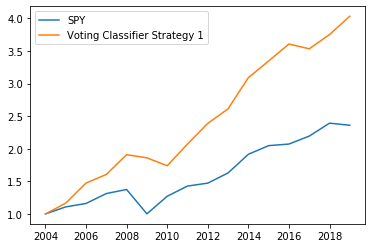

In [185]:
plt.plot(returns_spy_strategy_voting)
plt.legend(['SPY','Voting Classifier Strategy 1'])

In [187]:
voting_results = results.loc[results['model_type'] == 'voting_classifier_strat1']
print("Total PnL of Strategy Style 1: ", round(returns_spy_strategy_voting['strategy'][-1],2))
print("Sharpe Ratio:",  round(voting_results['sharpe_ratio'].values[0],2))
print("Information Ratio:", round(voting_results['information_ratio'].values[0],2))
print("Alpha:", round(voting_results['alpha'].values[0],2))
print("Max drawdown:", round(voting_results['max_drawdown'].values[0],2))

Total PnL of Strategy Style 1:  4.03
Sharpe Ratio: 1.21
Information Ratio: 1.13
Alpha: 0.18
Max drawdown: 0.17


In [188]:
strategy_returns_style2 = calc_strategy_returns_style2(training_data, training_labels, test_frames, test_data, top10features, voting_clf)

In [189]:
returns_spy_style2 = SPY.copy()

In [190]:
returns_spy_style2['strategy'] = strategy_returns_style2
results_graph_data['VotingClassifierStrat2'] = strategy_returns_style2

In [191]:
voting_returns_sd2 = np.std(returns_spy_style2['strategy'])

In [192]:
max_dd_returns_style2 = calc_max_drawdown(returns_spy_style2['strategy'])

C:\Users\eddie\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


In [194]:
sharpe_ratio_style2 = calc_sharpe_ratio(returns_spy_style2[['spy_cum_ret','strategy']])

In [195]:
strategy_ret_normalized_style2 = (returns_spy_style2['strategy'] - 1).diff().values[1:]
spy_ret_normalized_style2 = (returns_spy_style2['spy_cum_ret'] - 1).diff().values[1:]
information_ratio_style2 = calc_information_ratio(strategy_ret_normalized_style2, spy_ret_normalized_style2)

alpha_style2 = calc_alpha(strategy_ret_normalized_style2, spy_ret_normalized_style2)

In [196]:
results = results.append({"model_type":"voting_classifier_strat2", "hyper_parameters":voting_clf.get_params(), "max_drawdown":max_dd_returns_style2, 
                "sharpe_ratio":sharpe_ratio_style2, "alpha":alpha_style2, "information_ratio":information_ratio_style2,
                         "returns_sd": voting_returns_sd2}, ignore_index=True)

In [197]:
display(results)

,model_type,hyper_parameters,max_drawdown,sharpe_ratio,alpha,information_ratio,returns_sd
0,random_forest_strat1,"{'bootstrap': True, 'class_weight': None, 'cri...",0.406891,0.886202,0.168042,0.733543,1.106498
1,random_forest_strat2,"{'bootstrap': True, 'class_weight': None, 'cri...",0.071141,0.819332,0.043336,0.797313,0.223610
2,ada_boost_strat1,"{'algorithm': 'SAMME.R', 'base_estimator__clas...",0.192115,1.172459,0.155250,1.094747,0.818302
3,ada_boost_strat2,"{'algorithm': 'SAMME.R', 'base_estimator__clas...",0.040456,1.073291,0.049262,1.239814,0.204080
4,gradient_boost_strat1,"{'boosting_type': 'gbdt', 'class_weight': None...",0.049563,1.469581,0.155672,1.420951,0.805261
5,gradient_boost_strat2,"{'boosting_type': 'gbdt', 'class_weight': None...",0.021832,1.174899,0.052000,1.524780,0.200711
6,voting_classifier_strat1,"{'estimators': [('rf', RandomForestClassifier(...",0.169755,1.211199,0.177102,1.130995,0.957318
7,voting_classifier_strat2,"{'estimators': [('rf', RandomForestClassifier(...",0.081612,0.439447,0.010484,0.417524,0.195239


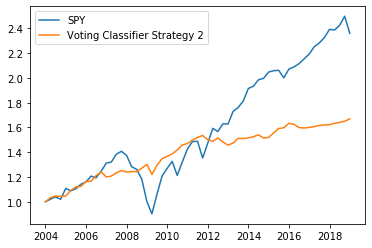

In [198]:
plt.plot(returns_spy_style2)
plt.legend(['SPY', 'Voting Classifier Strategy 2'])

In [199]:
print("Total PnL of Strategy Style 2: ", round(strategy_returns_style2[-1],2))
print("Sharpe Ratio:", round(sharpe_ratio_style2,2))
print("Information Ratio:", round(information_ratio_style2,2))
print("Alpha:", round(alpha_style2,2))
print("Max drawdown:", round(max_dd_returns_style2,2))

Total PnL of Strategy Style 2:  1.67
Sharpe Ratio: 0.44
Information Ratio: 0.42
Alpha: 0.01
Max drawdown: 0.08


# Final Results

In [203]:
display(results.sort_values(by = ['sharpe_ratio'], ascending = False))

,model_type,hyper_parameters,max_drawdown,sharpe_ratio,alpha,information_ratio,returns_sd
4,gradient_boost_strat1,"{'boosting_type': 'gbdt', 'class_weight': None...",0.049563,1.469581,0.155672,1.420951,0.805261
6,voting_classifier_strat1,"{'estimators': [('rf', RandomForestClassifier(...",0.169755,1.211199,0.177102,1.130995,0.957318
5,gradient_boost_strat2,"{'boosting_type': 'gbdt', 'class_weight': None...",0.021832,1.174899,0.052000,1.524780,0.200711
2,ada_boost_strat1,"{'algorithm': 'SAMME.R', 'base_estimator__clas...",0.192115,1.172459,0.155250,1.094747,0.818302
3,ada_boost_strat2,"{'algorithm': 'SAMME.R', 'base_estimator__clas...",0.040456,1.073291,0.049262,1.239814,0.204080
0,random_forest_strat1,"{'bootstrap': True, 'class_weight': None, 'cri...",0.406891,0.886202,0.168042,0.733543,1.106498
1,random_forest_strat2,"{'bootstrap': True, 'class_weight': None, 'cri...",0.071141,0.819332,0.043336,0.797313,0.223610
7,voting_classifier_strat2,"{'estimators': [('rf', RandomForestClassifier(...",0.081612,0.439447,0.010484,0.417524,0.195239


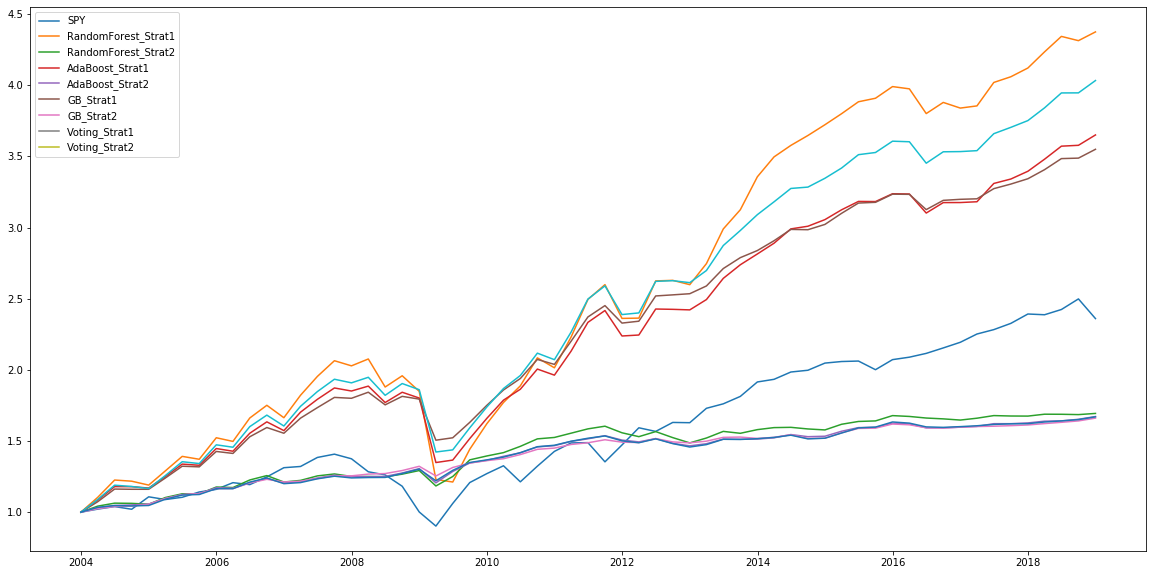

In [208]:
plt.plot(results_graph_data)
plt.legend(["SPY", 
             "RandomForest_Strat1", "RandomForest_Strat2", 
             "AdaBoost_Strat1","AdaBoost_Strat2",
             "GB_Strat1","GB_Strat2",
             "Voting_Strat1", "Voting_Strat2"])
plt.rcParams["figure.figsize"] = (15,10)

As we can see in our final results, each strategy has a varying amount of risk. Namely all models using trading strategy 1 have a huge drawdown near 2009, whereas trading strategy 2 in general maintains a much safer drawdown overall. In the long run however, all trading strategies 2 underperform versus the S&P. Overall, the strategy with the highest Sharpe ratio and relatively lowest max dradown is Gradient Boosted Trees w/ Strategy 1. 

There's a fair amount of correlation throughout all the strategies because of the large assumption we're making that the optimal set of features are the same static top 10 features throughout the entire backtest. A better but more computationally expensive backtest would involve calibrating a different set of optimal features for each quarter throughout the backtest, as well as recalibrating the hyperparameters each quarter.

Note that none of these strategies take into account execution/transaction costs, market impact or slippage. The backtested metrics are likely to be over-optimistic, and a productionized strategy will likely bring to light other assumptions that could erode our Sharpe ratios.